## Import libraries

In [32]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import data sets**

In [49]:
csv_path_train = '/content/drive/MyDrive/mashrooms-vision/train.csv'
csv_path_test = '/content/drive/MyDrive/mashrooms-vision/test.csv'
images_folder = '/content/drive/MyDrive/mashrooms-vision/dataset/dataset'
output_folder = '/content/drive/MyDrive/mashrooms-vision/sorted/'

In [50]:
train_data = pd.read_csv(csv_path_train)
test_data = pd.read_csv(csv_path_test)

In [56]:
train_data

,Image,Mushroom
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2360,2367,9
2361,2368,9
2362,2369,9
2363,2370,9


In [57]:
test_data

,Image
0,2372
1,2373
2,2374
3,2375
4,2376
...,...
593,2967
594,2968
595,2969
596,2970


### **Sort images by class**

In [5]:
os.makedirs(output_folder, exist_ok=True)

In [8]:
for _, row in train_data.iterrows():
    image_name = str(row['Image']).zfill(5) + '.jpg'
    label = str(row['Mushroom'])

    src = os.path.join(images_folder, image_name)
    dst_folder = os.path.join(output_folder, label)
    dst = os.path.join(dst_folder, image_name)

    os.makedirs(dst_folder, exist_ok=True)

    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"not found: {src}")

## **Dataset Feature Description**

This dataset contains images of mushrooms, with the goal of classifying them into their respective types. Each entry represents one mushroom, described by the following features:

**ImageID:** The filename or identifier of the mushroom image.

**Mushroom:** The class or type of the mushroom (e.g., Agaricus, Amanita, etc.).

### **Check which mushroom classes are in the dataset and count images per class**

In [55]:
class_order = sorted(train_data['Mushroom'].unique())
class_counts = train_data['Mushroom'].value_counts().reindex(class_order)
print("\nAmount images for each class:")
print(class_counts)


Amount images for each class:
Mushroom
0    238
1    240
2    240
3    222
4    227
5    240
6    238
7    240
8    240
9    240
Name: count, dtype: int64


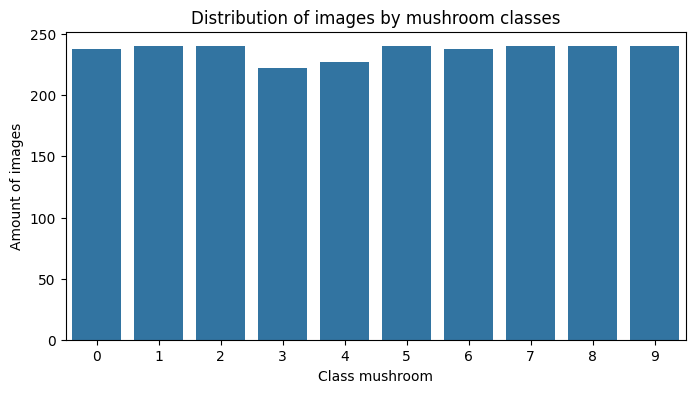

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(x='Mushroom', data=train_data, order=class_order)
plt.title("Distribution of images by mushroom classes")
plt.xlabel("Class mushroom")
plt.ylabel("Amount of images")
plt.show()